<a href="https://colab.research.google.com/github/alexander-toschev/cv-course/blob/main/ImageProcessing_Morphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Замена лиц

**Цель**

Посмотреть алгоритмы замены лиц


In [20]:
!pip install --upgrade pip
!pip install matplotlib
!pip install Pillow
!pip install image
!apt update
!apt install -y cmake
!pip install dlib
!wget "https://github.com/nicolasmetallo/eameo-faceswap-generator/raw/master/shape_predictor_68_face_landmarks.dat"
!wget https://github.com/alexander-toschev/cv-course/raw/main/data/donald_trump.jpg
!wget https://github.com/alexander-toschev/cv-course/raw/main/data/hillary_clinton.jpg

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

In [2]:
import numpy as np
import cv2
import sys
import dlib
from PIL import Image

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

Let’s start by obtaining corresponding points. First, we can get a lot of points by automatically ( or manually ) by detecting facial feature points. used dlib to detect 68 corresponding points. Next, I added four more points ( one on the right hand side ear, one on the neck, and two on the shoulders ). Finally, I added the corners of the image and half way points between those corners as corresponding points as well. Needless to say, one can add a few more points around the head and neck to get even better results, or remove the manually clicked points to get slightly worse ( but fully automatic ) results.

## Delaunay Triangulation
Calculate Delaunay triangulation

https://ru.wikipedia.org/wiki/%D0%A2%D1%80%D0%B8%D0%B0%D0%BD%D0%B3%D1%83%D0%BB%D1%8F%D1%86%D0%B8%D1%8F_%D0%94%D0%B5%D0%BB%D0%BE%D0%BD%D0%B5

Find location of feature points in morphed image : In the morphed image M, we can find the locations of all 80 points (x_m, y_m) using equation (1).

1. Calculate affine transforms : So we have a set of 80 points in image 1, another set of 80 points in image 2 and a third set of 80 points in the morphed image. We also know the triangulation defined over these points. Pick a triangle in image 1 and the corresponding triangle in the morphed image and calculate the affine transform that maps the three corners of the triangle in image 1 to the three corners of the corresponding triangle in the morphed image. In OpenCV, this can be done using getAffineTransform . Calculate an affine transform for every pair of 149 triangles. Finally, repeat the process of image 2 and the morphed image.
1. Warp triangles : For each triangle in image 1, use the affine transform calculated in the previous step to transform all pixels inside the triangle to the morphed image. Repeat this for all triangles in image 1 to obtain a warped version of image 1. Similarly, obtain a warped version for image 2. In OpenCV this is achieved by using the function warpAffine. However, warpAffine takes in an image and not a triangle. The trick is to calculate a bounding box for the triangle, warp all pixels inside the bounding box using warpAffine, and then mask the pixels outside the triangle. The triangular mask is created using fillConvexPoly. Be sure to use blendMode BORDER_REFLECT_101 while using warpAffine. 1. It hides the seams better than Secretary Clinton hides her emails.
1. Alpha blend warped images : In the previous step we obtained warped version of image 1 and image 2. These two images can be alpha blended using equation (2), and this is your final morphed image. In the code I have provided warping triangles and alpha blending them is combined in a single step.

In [4]:
import cv2
import dlib
import numpy as np
import math

# Returns 8 points on the boundary of a rectangle
def getEightBoundaryPoints(h, w):
  boundaryPts = []
  boundaryPts.append((0,0))
  boundaryPts.append((w/2, 0))
  boundaryPts.append((w-1,0))
  boundaryPts.append((w-1, h/2))
  boundaryPts.append((w-1, h-1))
  boundaryPts.append((w/2, h-1))
  boundaryPts.append((0, h-1))
  boundaryPts.append((0, h/2))
  return np.array(boundaryPts, dtype=np.float)


# Constrains points to be inside boundary
def constrainPoint(p, w, h):
  p = (min(max(p[0], 0), w - 1), min(max(p[1], 0), h - 1))
  return p

# convert Dlib shape detector object to list of tuples
def dlibLandmarksToPoints(shape):
  points = []
  for p in shape.parts():
    pt = (p.x, p.y)
    points.append(pt)
  return points

# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False)
  return tform

# Normalizes a facial image to a standard size given by outSize.
# Normalization is done based on Dlib's landmark points passed as pointsIn
# After normalization, left corner of the left eye is at (0.3 * w, h/3 )
# and right corner of the right eye is at ( 0.7 * w, h / 3) where w and h
# are the width and height of outSize.
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize

  # Corners of the eye in input image
  eyecornerSrc = [pointsIn[36], pointsIn[45]]

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)), 
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform, (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, (pointsIn.shape[0], 1, pointsIn.shape[1]))
  
  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut, (pointsIn.shape[0], pointsIn.shape[1]))

  return imOut, pointsOut

# find the point closest to an array of points
# pointsArray is a Nx2 and point is 1x2 ndarray
def findIndex(pointsArray, point):
  dist = np.linalg.norm(pointsArray-point, axis=1)
  minIndex = np.argmin(dist)
  return minIndex


# Check if a point is inside a rectangle
def rectContains(rect, point):
  if point[0] < rect[0]:
    return False
  elif point[1] < rect[1]:
    return False
  elif point[0] > rect[2]:
    return False
  elif point[1] > rect[3]:
    return False
  return True


# Calculate Delaunay triangles for set of points
# Returns the vector of indices of 3 points for each triangle
def calculateDelaunayTriangles(rect, points):

  # Create an instance of Subdiv2D
  subdiv = cv2.Subdiv2D(rect)

  # Insert points into subdiv
  for p in points:
    subdiv.insert((p[0], p[1]))

  # Get Delaunay triangulation
  triangleList = subdiv.getTriangleList()

  # Find the indices of triangles in the points array
  delaunayTri = []

  for t in triangleList:
    # The triangle returned by getTriangleList is
    # a list of 6 coordinates of the 3 points in
    # x1, y1, x2, y2, x3, y3 format.
    # Store triangle as a list of three points
    pt = []
    pt.append((t[0], t[1]))
    pt.append((t[2], t[3]))
    pt.append((t[4], t[5]))

    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
      # Variable to store a triangle as indices from list of points
      ind = []
      # Find the index of each vertex in the points list
      for j in range(0, 3):
        for k in range(0, len(points)):
          if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
            ind.append(k)
        # Store triangulation as a list of indices
      if len(ind) == 3:
        delaunayTri.append((ind[0], ind[1], ind[2]))

  return delaunayTri

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size):

  # Given a pair of triangles, find the affine transform.
  warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

  # Apply the Affine Transform just found to the src image
  dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None,
             flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

  return dst

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2):
  # Find bounding rectangle for each triangle
  r1 = cv2.boundingRect(np.float32([t1]))
  r2 = cv2.boundingRect(np.float32([t2]))

  # Offset points by left top corner of the respective rectangles
  t1Rect = []
  t2Rect = []
  t2RectInt = []

  for i in range(0, 3):
    t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
    t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    t2RectInt.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

  # Get mask by filling triangle
  mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
  cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0)

  # Apply warpImage to small rectangular patches
  img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]

  size = (r2[2], r2[3])

  img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)

  img2Rect = img2Rect * mask

  # Copy triangular region of the rectangular patch to the output image
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

# detect facial landmarks in image
def getLandmarks(faceDetector, landmarkDetector, im, FACE_DOWNSAMPLE_RATIO = 1):
  points = []
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO, 
                       fy=1.0/FACE_DOWNSAMPLE_RATIO, 
                       interpolation = cv2.INTER_LINEAR)
  
  faceRects = faceDetector(imSmall, 0)
  
  if len(faceRects) > 0:
    maxArea = 0
    maxRect = None
    # TODO: test on images with multiple faces
    for face in faceRects:
      if face.area() > maxArea:
        maxArea = face.area()
        maxRect = [face.left(),
                   face.top(),
                   face.right(),
                   face.bottom()
                  ]
    
    rect = dlib.rectangle(*maxRect)
    scaledRect = dlib.rectangle(int(rect.left()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.top()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.right()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.bottom()*FACE_DOWNSAMPLE_RATIO))
    
    landmarks = landmarkDetector(im, scaledRect)
    points = dlibLandmarksToPoints(landmarks)
  return points

# Warps an image in a piecewise affine manner.
# The warp is defined by the movement of landmark points specified by pointsIn
# to a new location specified by pointsOut. The triangulation beween points is specified
# by their indices in delaunayTri.
def warpImage(imIn, pointsIn, pointsOut, delaunayTri):
  h, w, ch = imIn.shape
  # Output image
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Warp each input triangle to output triangle.
  # The triangulation is specified by delaunayTri
  for j in range(0, len(delaunayTri)):
    # Input and output points corresponding to jth triangle
    tin = []
    tout = []

    for k in range(0, 3):
      # Extract a vertex of input triangle
      pIn = pointsIn[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pIn = constrainPoint(pIn, w, h)

      # Extract a vertex of the output triangle
      pOut = pointsOut[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pOut = constrainPoint(pOut, w, h)

      # Push the input vertex into input triangle
      tin.append(pIn)
      # Push the output vertex into output triangle
      tout.append(pOut)

    # Warp pixels inside input triangle to output triangle.
    warpTriangle(imIn, imOut, tin, tout)
  return imOut

In [77]:
from skimage import io
# !ls
filename1 = "donald_trump.jpg"
filename2 = "hillary_clinton.jpg"

alpha = 0.5
    
# Read images
img1 = cv2.imread(filename1,1);
img2 = cv2.imread(filename2,1);
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
points1 = getLandmarks(detector, predictor, img1)
print(points1)
points2 = getLandmarks(detector, predictor, img2)

[(84, 314), (84, 360), (87, 408), (92, 456), (101, 503), (119, 548), (149, 583), (185, 608), (231, 617), (283, 610), (338, 589), (391, 565), (433, 527), (462, 483), (477, 433), (483, 379), (489, 325), (107, 262), (124, 240), (153, 235), (183, 242), (213, 254), (277, 260), (313, 247), (351, 242), (387, 251), (415, 275), (241, 300), (237, 328), (233, 355), (229, 384), (203, 419), (217, 424), (232, 428), (251, 426), (271, 422), (141, 302), (159, 292), (182, 293), (198, 310), (179, 313), (157, 311), (308, 313), (329, 299), (353, 298), (373, 310), (353, 318), (330, 317), (177, 503), (196, 484), (217, 472), (231, 477), (246, 474), (273, 489), (302, 510), (273, 525), (246, 530), (230, 529), (214, 526), (194, 517), (190, 500), (217, 489), (232, 491), (247, 491), (289, 506), (246, 509), (231, 508), (215, 505)]


# Plot the triangles
Plot triangles on the image

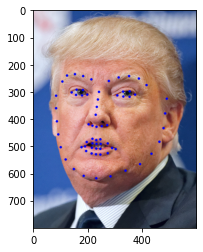

In [78]:
# Draw a point
def draw_point(img, p, color ) :
    cv2.circle( img, p, 4, color, cv2.FILLED, cv2.LINE_AA, 0 )


draw_img = np.copy(img1)

for t in points1 :
    draw_point(draw_img, t, (255,0,0))

plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))

Delayneo triangulation by points


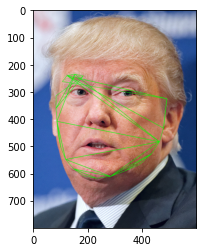

In [79]:
# Check if a point is inside a rectangle
def rect_contains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True


# Draw delaunay triangles
def draw_delaunay(img, triangleList, points, delaunay_color ) :
  
    size = img.shape
    r = (0, 0, size[1], size[0])

    for t in triangleList :
        pt1 = points[t[0]]
        pt2 = points[t[1]]
        pt3 = points[t[2]]
        if rect_contains(r, pt1) and rect_contains(r, pt2) and rect_contains(r, pt3) :
        
            cv2.line(img, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(img, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)


# Find convex hull
# выпуклая оболочка
hull1 = []
hull2 = []

hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)
          
for i in range(0, len(hullIndex)):
    hull1.append(points1[int(hullIndex[i])])
    hull2.append(points2[int(hullIndex[i])])
    
    
# Find delanauy traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])
dt = calculateDelaunayTriangles(rect, hull2)
draw =  np.copy(img1)
draw_delaunay(draw,  dt, points1, (0,255,0))
plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB))

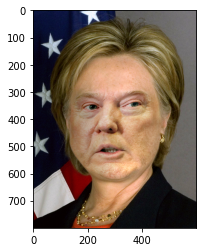

In [80]:


img1Warped = np.copy(img2);    
# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []        
#get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
       t1.append(hull1[dt[i][j]])
       t2.append(hull2[dt[i][j]])
       
    warpTriangle(img1, img1Warped, t1, t2)   
    
            
# Calculate Mask
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))
    
mask = np.zeros(img2.shape, dtype = img2.dtype)  
    
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
    
r = cv2.boundingRect(np.float32([hull2]))    
    
center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
        
    
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    